<a href="https://colab.research.google.com/github/danplotkin/BrainCancerClassification/blob/main/brain_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
!pip install opendatasets

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import random
import shutil
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
import io
import opendatasets as od

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg11_bn, VGG11_BN_Weights
from torchvision.datasets import ImageFolder

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

# Load in Data

In [ ]:
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [ ]:
# define data paths
BASE_DIR = '/content/brain-tumor-mri-dataset/'
TRAINING_FOLDER = os.path.join(BASE_DIR, 'Training')
TESTING_FOLDER = os.path.join(BASE_DIR, 'Testing')
VAL_FOLDER = os.path.join(BASE_DIR, 'Validation')
CLASSES = sorted(os.listdir(TRAINING_FOLDER))

### Create Validation Set

In [ ]:
# get image files
image_files = glob.glob(os.path.join(TRAINING_FOLDER, '**/*.jpg'), recursive=True)

selected_images = random.sample(image_files, int(len(image_files)*0.2))

# Move the selected images to the validation directory
for image_path in tqdm(selected_images):
    # get the class name from the parent directory
    class_folder = os.path.basename(os.path.dirname(image_path))

    # create a new folder in the validation directory for the current class
    val_class_path = os.path.join(VAL_FOLDER, class_folder)
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path)

    # Move the image to the corresponding validation class folder
    val_image_path = os.path.join(val_class_path, os.path.basename(image_path))
    shutil.move(image_path, val_image_path)

  0%|          | 0/914 [00:00<?, ?it/s]

In [ ]:
folders = [TRAINING_FOLDER, VAL_FOLDER, TESTING_FOLDER]
train_size, val_size, test_size = [len(glob.glob(os.path.join(folder, '**/*.jpg'), recursive=True)) for folder in folders]

print(f'Train size: {train_size}\nValidation Size: {val_size}\nTest Size: {test_size}')

Train size: 3656
Validation Size: 2056
Test Size: 1311


# EDA

We will construct a pipeline class for our EDA.

In [ ]:
class EDA:
    def __init__(self, training_folder, testing_folder, valid_folder, classes):
        self.training_folder = training_folder
        self.testing_folder = testing_folder
        self.valid_folder = valid_folder
        self.classes = classes

    def _get_training_samples(self):
        """
        Function to retrieve a list of one sample per each class.
        """
        paths = [os.path.join(self.training_folder, cls) for cls in self.classes]
        img_paths = {}
        for path, cls in zip(paths, self.classes):
            img_name = sorted(os.listdir(path))[0]
            img_paths[cls] = os.path.join(path, img_name)
        return img_paths

    def _get_counts(self, set_type):
        """
        Function to get the counts of each class in a given set.

        Args:
         `set_type` (str): Which set to get counts for. Options are `train` and `test`.

        Returns: Dictionary of counts.
        """
        if set_type=='train':
            folder = self.training_folder
        elif set_type=='test':
            folder = self.testing_folder
        else:
            folder = self.valid_folder

        counts = {}

        # iterate through classes
        for class_type in self.classes:
            dir = os.path.join(folder, class_type)
            counts[class_type] = len(os.listdir(dir))
        return counts

    def plot_samples(self):
        """
        Function to plot training samples.
        """
        fig, ax = plt.subplots(1, 4, figsize=(10, 6))
        for idx, data in enumerate(self._get_training_samples().items()):
            cls, path = data
            img = cv2.imread(path)
            ax[idx].imshow(img)
            ax[idx].set_title(cls)
            ax[idx].axis('off')
        plt.show()

    def plot_counts(self, set_type):
        """
        Function to plot distribution counts.

        Args:
        `set_type` (str): Which set to plot counts for. Options are `train` and `test`.
        """
        counts = self._get_counts(set_type=set_type)
        X = list(counts.keys())
        y = list(counts.values())

        # plot counts
        plt.bar(X, y)
        plt.title(f'{set_type.capitalize()} Set Distributions')
        plt.xlabel('Class')
        plt.ylabel('Counts')
        plt.show()

In [ ]:
# initialize explorer
eda = EDA(TRAINING_FOLDER, TESTING_FOLDER, VAL_FOLDER, CLASSES)

### Data Distribution

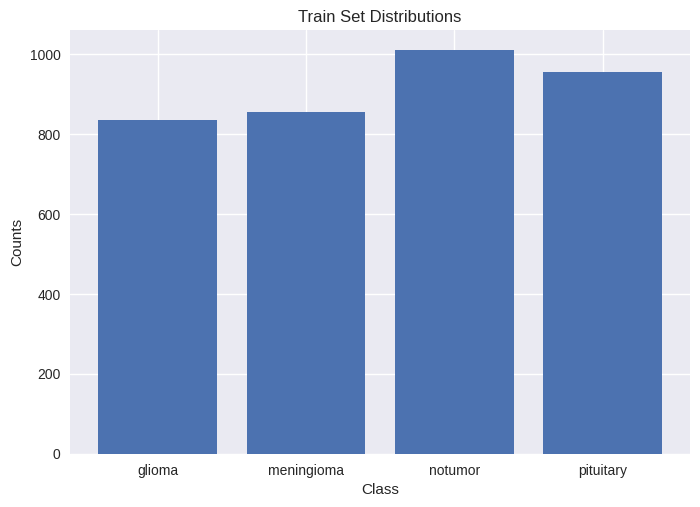

In [ ]:
# plot train counts
eda.plot_counts('train')

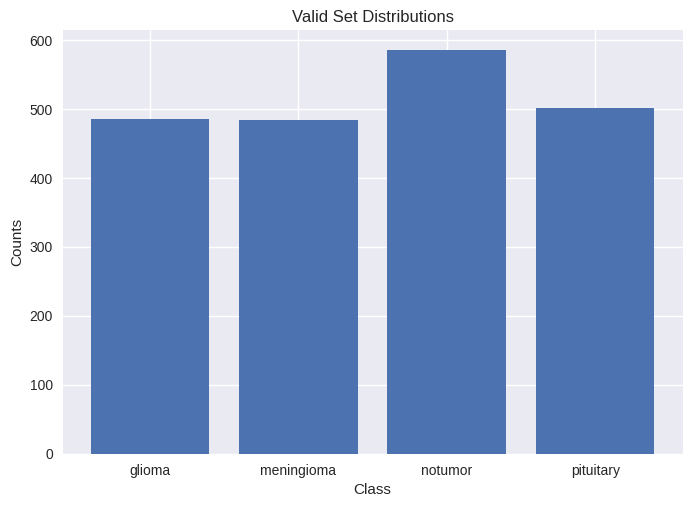

In [ ]:
# plot validation counts
eda.plot_counts('valid')

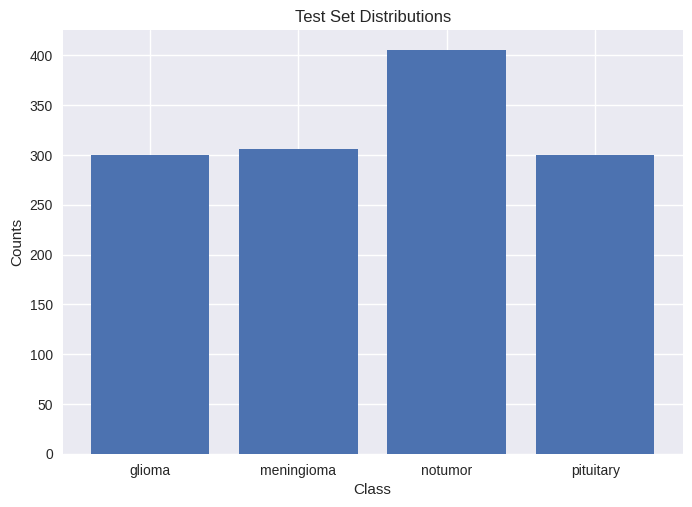

In [ ]:
# plot test counts
eda.plot_counts('test')

### Plot Samples

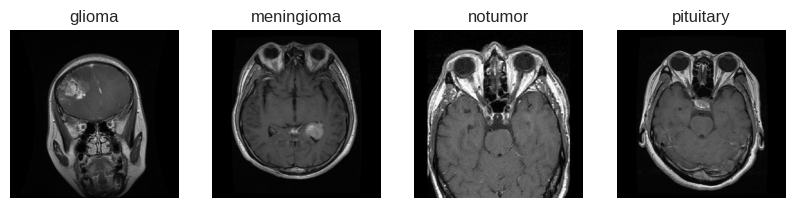

In [ ]:
eda.plot_samples()

# Preprocess Data

In [ ]:
class Config:
    batch_size = 32
    epochs = 50
    lr = 1e-4
    n_classes = len(CLASSES)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Augment Data

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip()
])

val_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Load in Datasets

In [ ]:
# create datasets
train_dataset = ImageFolder(TRAINING_FOLDER, transform=train_transforms)
val_dataset = ImageFolder(VAL_FOLDER, transform=val_transformations)
test_dataset = ImageFolder(TESTING_FOLDER, transform=val_transformations)

assert train_dataset.classes == val_dataset.classes == test_dataset.classes

In [ ]:
train_dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

### Batch Datasets

In [ ]:
# batch sets
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

In [ ]:
for ex_inputs, ex_classes in train_loader:
    print(f"Image shape: {ex_inputs.shape}, Label Shape: {ex_classes.shape}")
    break

Image shape: torch.Size([32, 3, 224, 224]), Label Shape: torch.Size([32])


# Build Model

Below we will build our CNN using the `torch.nn.Module` class and the VGG-11 pretrained architecture.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # load in vgg
        vgg = vgg11_bn(weights=VGG11_BN_Weights)
        num_input_features = vgg.classifier[6].in_features

        # freeze layers
        for param in vgg.parameters():
            param.requires_grad = False

        # define feed forward network
        vgg.classifier[6] = nn.Linear(num_input_features, num_classes)
        for param in vgg.classifier.parameters():
            param.requires_grad = True

        self.model = vgg

    def forward(self, x):
        return self.model(x)

### Create Early Stopping Callback

We will first create an early stopping callback that will stop our training and restore the best weights when a certain patience interval is hit.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

### Define Training Class

Below we will define a class that will be used as our trainer. This will train our model, evaluate our model, save our model weights, incorporate our early stopping, plot training, and predict.

In [ ]:
class BrainTumorClassification:
    def __init__(self, model, optimizer, criterion, val_transformations, train_dataset, config):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.output_folder = 'torch_models/'
        self.history = {}
        self.val_transformations = val_transformations
        self.classes = train_dataset.classes
        self.Config = config

    def _train_epoch(self, training_loader):
        """
        Train a single epoch of the model.

        Args:
            training_loader (torch.utils.data.DataLoader): The PyTorch data loader object for the training set.

        Returns:
            Tuple of floats: The average training accuracy and average training loss for the epoch.
        """
        running_loss = 0.00
        total_correct = 0
        total_samples = 0

        self.model.train()
        prog_bar = tqdm(enumerate(training_loader), total=len(training_loader))
        for batch_idx, (imgs, labels) in prog_bar:

            # configure to device
            imgs, labels = imgs.to(self.Config.device), labels.to(self.Config.device)

            # zero out gradients
            self.optimizer.zero_grad()

            # forward pass
            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels)

            # backward pass
            loss.backward()
            self.optimizer.step()

            # calculate loss of batch in average
            running_loss += loss.item()

            # calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            n_correct = torch.sum(preds == labels)
            total_correct += n_correct
            total_samples += len(labels)

            prog_bar.set_description(f"Batch {batch_idx+1}/{len(training_loader)} - Avg Train Loss: {running_loss/(batch_idx+1):.4f}, Avg Train Accuracy: {(total_correct/total_samples):.4f}")

        running_loss /= len(training_loader)
        total_accuracy = float(total_correct / total_samples)

        return total_accuracy, running_loss

    @torch.no_grad()
    def _eval_epoch(self, eval_loader, return_metrics=True):
        """
        Evaluates the performance of the model on a validation set for a single epoch.

        Args:
            eval_loader (torch.utils.data.dataloader.DataLoader): PyTorch validation loader.
            return_metrics (bool): Whether to return the evaluation metrics (accuracy and loss).

        Returns:
            tuple: A tuple containing the evaluation metrics. The first element is the average validation accuracy,
            and the second element is the average validation loss.
        """
        running_loss = 0.00
        total_correct = 0
        total_samples = 0

        self.model.eval()
        prog_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
        for batch_idx, (imgs, labels) in prog_bar:

            # configure to device
            imgs, labels = imgs.to(self.Config.device), labels.to(self.Config.device)

            # forward pass
            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels)

            # calculate loss of batch in average
            running_loss += loss.item()

            # calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            n_correct = torch.sum(preds == labels)
            total_correct += n_correct
            total_samples += len(labels)

            prog_bar.set_description(f"Batch {batch_idx+1}/{len(eval_loader)} - Avg Val Loss: {running_loss/(batch_idx+1):.4f}, Avg Val Accuracy: {(total_correct/total_samples):.4f}")

        running_loss /= len(eval_loader)
        total_accuracy = float(total_correct / total_samples)
        if return_metrics:
            return total_accuracy, running_loss

    def train(self, training_loader, eval_loader, num_epochs, output_dir):
        """
        Method to train the model for a given number of epochs using the provided training and evaluation data loaders.

        Args:
            training_loader (torch.utils.data.dataloader.DataLoader): PyTorch data loader for training data.
            eval_loader (torch.utils.data.dataloader.DataLoader): PyTorch data loader for evaluation data.
            num_epochs (int): Number of epochs to train the model.
            output_dir (str): Path to the directory where the trained model will be saved.

        Returns:
            None. Trains the model and saves it to the specified output directory.
        """

        # create output directory
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)
        file_dir = os.path.join(self.output_folder, output_dir)

        # initialize metrics
        train_accuracies, train_losses = [], []
        val_accuracies, val_losses = [], []

        # define early stopping variables
        early_stopper = EarlyStopping()
        best_epoch = 0
        best_val_loss = np.inf

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # train one epoch
            train_acc, train_loss = self._train_epoch(training_loader)
            train_accuracies.append(train_acc)
            train_losses.append(train_loss)

            # eval one epoch
            val_acc, val_loss = self._eval_epoch(eval_loader)
            val_accuracies.append(val_acc)
            val_losses.append(val_loss)

            print()

            # update best model weights
            if val_loss < best_val_loss:
                best_val_loss = val_loss # update best val loss
                best_epoch = epoch+1 # update best epoch for best val loss

            # check for early stopping
            if early_stopper(self.model, val_loss):
                print(f"Validation loss has not improved for {early_stopper.patience} epochs. Early stopping...")
                print(f"Reverting back to weights for epoch {best_epoch}.")
                break

        # end of training
        print('Training Finished!')


        # save model
        torch.save(self.model, file_dir)

        # get history
        self.history = {
            'accuracy': {'train': train_accuracies, 'eval': val_accuracies},
            'loss': {'train': train_losses, 'eval': val_losses}
        }

    def plot_training(self):
        """
        Plots the training and validation accuracy and loss over each epoch. Retrieves the accuracy and loss
        values from the `self.history` dictionary and creates two subplots to display the accuracy and loss
        data separately.
        """

        # Get the accuracy and loss values from self.history
        train_accuracies = self.history['accuracy']['train']
        val_accuracies = self.history['accuracy']['eval']
        train_losses = self.history['loss']['train']
        val_losses = self.history['loss']['eval']

        # Create subplots for accuracy and loss plots
        fig, axs = plt.subplots(2, 1, figsize=(10, 6))
        fig.subplots_adjust(hspace=0.5)

        # Plot training and validation accuracies
        axs[0].plot(train_accuracies, label='Training accuracy')
        axs[0].plot(val_accuracies, label='Validation accuracy')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        # Plot training and validation losses
        axs[1].plot(train_losses, label='Training loss')
        axs[1].plot(val_losses, label='Validation loss')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.show()

    def evaluate(self, test_loader):
        """
        Evaluates the model on a given test loader and returns the accuracy and loss metrics. Uses the
        `_eval_epoch` method to calculate the metrics for each batch in the loader and returns the final
        metrics for the entire dataset.

        Args:
            test_loader (torch.utils.data.dataloader.DataLoader): PyTorch DataLoader for the test dataset

        Returns:
            Tuple of the average accuracy and loss for the test dataset
        """
        return self._eval_epoch(test_loader, return_metrics=False)

    @torch.no_grad()
    def predict(self, img):
        """
        Takes an image and returns the predicted class label. Applies the validation transformations to the
        image, performs a forward pass through the model, and returns the predicted class.

        Args:
            img: PIL Image object of the input image

        Returns:
            The predicted class label as a string
        """
        self.model.eval()
        img = self.val_transformations(img)
        img = torch.unsqueeze(img, 0)
        img = img.to(self.Config.device)
        pred = self.model(img)
        pred_idx = torch.argmax(pred, dim=1)
        return self.classes[pred_idx]

### Initialize Model

In [ ]:
# initialize params
model = Net(num_classes=Config.n_classes).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:04<00:00, 129MB/s]


In [ ]:
# initialize classifier
classifier = BrainTumorClassification(
    model,
    optimizer,
    criterion,
    val_transformations,
    train_dataset,
    Config
)

# Train Model

We will now begin the intitial training of our CNN.

### Run Training Loop

In [ ]:
classifier.train(
    training_loader=train_loader,
    eval_loader=val_loader,
    num_epochs=Config.epochs,
    output_dir='brain_tumor_classification_cnn'
)

Epoch 1/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 2/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 3/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 5/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 6/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 7/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 8/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 10/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 11/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 12/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 13/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 15/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 16/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 17/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 18/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 20/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 21/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Validation loss has not improved for 5 epochs. Early stopping...
Reverting back to weights for epoch 16.
Training Finished!


### Visualize Training

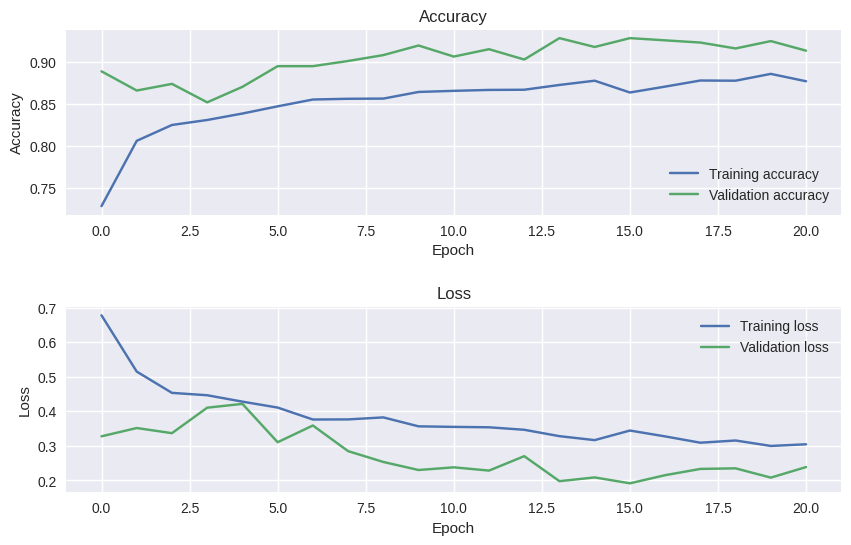

In [ ]:
classifier.plot_training()

### Evaluate on Testing Data

In [ ]:
classifier.evaluate(test_loader)

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
classifier.evaluate(val_loader)

  0%|          | 0/36 [00:00<?, ?it/s]

# Fine-Tune Model

We will now use the model we just trained to fine-tune the model further. We will freeze all of the layers except the last few convolutional layers. We unfreeze the last couple convolutional layers because the initial layers in the model capture low-level features such as edges and lines, while the later layers capture higher-level features such as shapes and objects, which are specific to the task in hand.

### Load in Trained Model

In [ ]:
model_base = torch.load('/content/torch_models/brain_tumor_classification_cnn').to(Config.device)

### Unfreeze Layers

In [ ]:
# freeze layers
for param in model_base.parameters():
    param.requires_grad = False

# unfreeze last few convolutional layers
for param in model_base.model.features[22:].parameters():
    param.requires_grad = True

# check that layers are frozen
for name, param in model_base.named_parameters():
    if param.requires_grad:
        print(name)

model.features.22.weight
model.features.22.bias
model.features.23.weight
model.features.23.bias
model.features.25.weight
model.features.25.bias
model.features.26.weight
model.features.26.bias


### Run Training Loop

We will create a new optimizer using our base model parameters. We will use a smaller learning rate than what was used in the original tuning. This is to prevent overfitting to the new data and to allow the model to adjust the earlier layers to better match the new data.

In [ ]:
optimizer = optim.Adam(model_base.parameters(), lr=1e-5)

In [ ]:
# initialize classifier
classifierV2 = BrainTumorClassification(
    model_base,
    optimizer,
    criterion,
    val_transformations,
    train_dataset,
    Config
)

In [ ]:
classifierV2.train(
    training_loader=train_loader,
    eval_loader=val_loader,
    num_epochs=Config.epochs,
    output_dir='brain_tumor_classification_cnn_tuned'
)

Epoch 1/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 2/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 3/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 5/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 6/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 7/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 8/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 10/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 11/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 12/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 13/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 15/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 16/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 17/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 18/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 20/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 21/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 22/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 23/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 24/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 25/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 26/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 27/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 28/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 29/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 30/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 31/50


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Validation loss has not improved for 5 epochs. Early stopping...
Reverting back to weights for epoch 26.
Training Finished!


### Visualize training

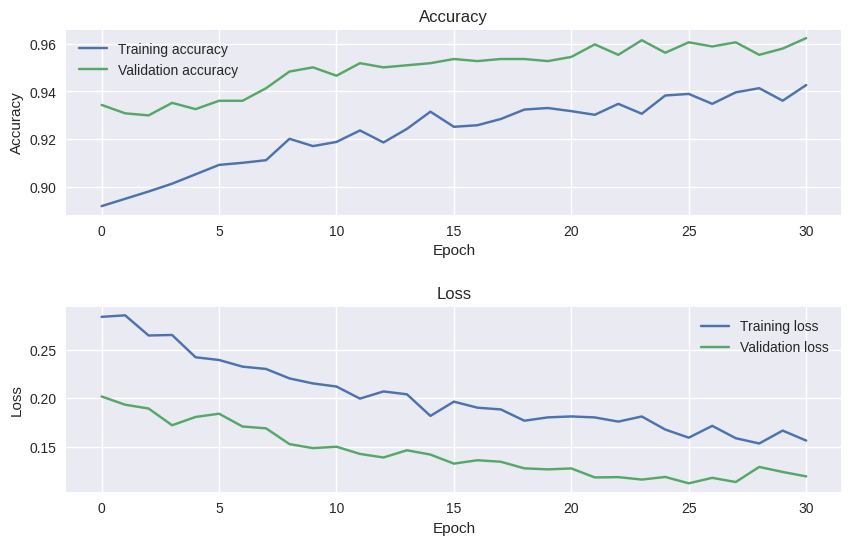

In [ ]:
classifierV2.plot_training()

### Test on Testing Data

In [ ]:
classifierV2.evaluate(test_loader)

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
classifierV2.evaluate(val_loader)

  0%|          | 0/36 [00:00<?, ?it/s]